(quantum-circuit-mps-example)=

# Quantum Circuits with MPS

While the standard method for circuit simulation (see [](#quantum-circuit-example)) uses a lazy tensor network representation of the entire quantum circuit before deciding what to compute, `quimb` also has support for simulating quantum circuits using matrix product states (MPS), which instead 'eagerly' contracts gates in and performs compression to maintain an MPS form of the full wavefunction.

In [1]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import quimb.tensor as qtn

We'll define a test circuit that is A) too large for state-vector simulation and B) too deep for exact contraction. It has arbitrarily long-range CZ entangling gates but depending on how small the angles of the single qubit U3 random rotations are, only builds up entanglement in a controlled manner.

In [2]:
def gen_gates(N=64, x=0.1, depth=10, seed=42):
    """Generate a long range circuit that only slowly builds up entanglement.

    Parameters
    ----------
    N : int, optional
        The number of qubits.
    x : float, optional
        The average angle magnitude of U3 rotations.
    depth : int, optional
        The number of fully entangling gate layers.
    seed : int, optional
        A random seed.

    Yields
    ------
    qtn.Gate
    """

    rng = np.random.default_rng(seed)
    qubits = list(range(N))

    for _ in range(depth):
        # random small single qubit rotations
        for q in qubits:
            yield qtn.Gate("U3", params=rng.normal(scale=x, size=3), qubits=[q])

        # random CZs between arbitrary qubit pairs
        rng.shuffle(qubits)
        for i in range(0, N, 2):
            qa = qubits[i]
            qb = qubits[i + 1]
            yield qtn.Gate("CZ", params=(), qubits=[qa, qb])

You can see that a very quick estimate of the amplitude brute-force contraction complexity gives a cost of $\sim 10^{30}$ FLOPs, while this could be improved, its clearly not a circuit that is easy to simulate exactly.

In [3]:
circ_ex = qtn.Circuit.from_gates(gen_gates())
circ_ex.amplitude_rehearse(optimize="greedy")

{'tn': TensorNetworkGenVector(tensors=672, indices=448),
 'tree': <ContractionTree(N=672)>,
 'W': 77.0,
 'C': 28.60123015407627}

## `CircuitMPS`

Instead we can use the [`CircuitMPS`](quimb.tensor.circuit.CircuitMPS) class to simulate the circuit. This class is a subclass of [`Circuit`](quimb.tensor.circuit.Circuit) and has the same API for applying gates, but each time it does so it contracts the gate into the MPS representation of the wavefunction. The core gate contraction methods is uses to do so are:

- [`MatrixProductState.gate_split`](quimb.tensor.tensor_1d.MatrixProductState.gate_split) - to contract a local gate into the MPS
- [`MatrixProductState.gate_with_auto_swap`](quimb.tensor.tensor_1d.MatrixProductState.gate_with_auto_swap) - to contract a non-local gate into the MPS, with automatic swapping of qubits if needed
- [`MatrixProductState.gate_nonlocal`](quimb.tensor.tensor_1d.MatrixProductState.gate_nonlocal) - to contract a non-local gate into the MPS, via an MPO representation that can handle multi-qubit gates and controls.

The default `gate_contract` method is ``"auto-mps"``, which uses ``"swap+split"`` for 2-qubit gates and ``"nonlocal"`` for 3+ qubit gates.

The [`CircuitMPS`](quimb.tensor.circuit.CircuitMPS) class can be created in the same ways as a normal [`Circuit`](quimb.tensor.circuit.Circuit),
but be aware that the gates are immediately contracted into the wavefunction and so the computation happens immediately. The ``progbar=True`` kwarg can thus be a useful to pass on to ``circ.apply_gates`` to see the progress of the simulation.

In [4]:
circ = qtn.CircuitMPS.from_gates(
    gates=gen_gates(),
    max_bond=None,
    cutoff=1e-6,
    progbar=True,
)

  0%|          | 0/960 [00:00<?, ?it/s]

max_bond=143, error~=0.00309: 100%|##########| 960/960 [00:25<00:00, 37.68it/s] 


You can see that the maximum bond dimension of the MPS has risen to 143 (out of a possible $2^{N / 2}$ to represent an arbitrary state!), and we have incurred an approximate error of 0.003. The error is calculated as:


$$
\epsilon = 1 - \left| \langle \psi | \psi \rangle \right|^2
\approx 1 - \left| \langle \psi_\mathrm{ideal} | \psi \rangle \right|^2
= 1 - F
$$

with $F$ being the true fidelity between the ideal and approximate states.

The MPS wavefunction is can be retrieved with the `CircuitMPS.psi` property:

In [5]:
circ.psi.show()

     2 4 7 10 11 13 18 25 34 37 39 40 50 48 52 64 73 77 87 94 103 107 111     
... >─>─>─>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>━━━>━━━>━━━> ...
    │ │ │ │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │   │   │   │    
                                 ...                                  
    117 134 136 133 140 135 141 143 138 142 128 129 127 124 123 109 123 11    
... ━━━>━━━>━━━>━━━>━━━●━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━━<━━ ...
       │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │      
                                 ...                                  
    5 105 102 90 87 76 74 75 66 60 49 43 32 27 23 20 15 12 11 7 5 3 2 
    ━<━━━<━━━<──<──<──<──<──<──<──<──<──<──<──<──<──<──<──<──<─<─<─<─<
     │   │   │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ │ │ │ │


Note some of the methods of `Circuit` may not be supported by `CircuitMPS` - it is recommended to work directly with the MPS tensor network.

## CircuitPermMPS


Another simple variant is [`CircuitPermMPS`](quimb.tensor.circuit.CircuitPermMPS), which is a subclass of [`CircuitMPS`](quimb.tensor.circuit.CircuitMPS) that uses the ``'swap+split'`` to apply non-local 2-qubit gates, but *doesn't* swap the qubits back, and instead lazily tracks the qubit locations. This can be quite advantageous for circuits without an expectation of locality, such as here:

In [6]:
circ = qtn.CircuitPermMPS.from_gates(
    gates=gen_gates(),
    max_bond=None,
    cutoff=1e-6,
    progbar=True,
)

max_bond=99, error~=0.00175: 100%|##########| 960/960 [00:10<00:00, 88.76it/s]  


You can see that the maximum bond dimension is lower, and the error is also lower. Note however that for efficiency the qubits are left in their swapped positions, and the `circ.psi` attribute now returns a generic [`TensorNetworkGenVector`](quimb.tensor.tensor_arbgeom.TensorNetworkGenVector) object with the indices and tags out of order:

In [7]:
tn = circ.psi
tn

TensorNetworkGenVector(tensors=64, indices=127)

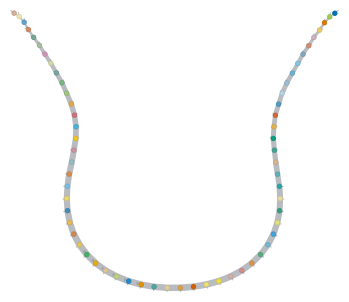

In [8]:
tn.draw(tn.site_tags, node_scale=0.5)

To get the non-reindexed and non-retagged MPS you can call [`CircuitPermMPS.get_psi_unordered`](quimb.tensor.circuit.CircuitPermMPS.get_psi_unordered):

In [9]:
mps = circ.get_psi_unordered()
mps

MatrixProductState(tensors=64, indices=127, L=64, max_bond=99)

The current qubit ordering is stored in `circ.qubits` and so the mapping of qubits to the physical sites of this MPS can be calculated like so:

In [10]:
{q: circ.qubits.index(q) for q in range(circ.N)}

{0: 0,
 1: 43,
 2: 6,
 3: 11,
 4: 35,
 5: 61,
 6: 9,
 7: 8,
 8: 22,
 9: 45,
 10: 10,
 11: 7,
 12: 50,
 13: 23,
 14: 47,
 15: 17,
 16: 18,
 17: 33,
 18: 55,
 19: 15,
 20: 14,
 21: 20,
 22: 59,
 23: 24,
 24: 39,
 25: 54,
 26: 58,
 27: 53,
 28: 1,
 29: 36,
 30: 56,
 31: 21,
 32: 28,
 33: 29,
 34: 62,
 35: 44,
 36: 49,
 37: 3,
 38: 19,
 39: 40,
 40: 38,
 41: 42,
 42: 32,
 43: 13,
 44: 34,
 45: 52,
 46: 37,
 47: 31,
 48: 2,
 49: 25,
 50: 16,
 51: 46,
 52: 30,
 53: 41,
 54: 63,
 55: 60,
 56: 12,
 57: 5,
 58: 27,
 59: 26,
 60: 51,
 61: 48,
 62: 4,
 63: 57}

## Using a GPU or other backends

We can make use of GPUs or other accelerated backends by simply supplying a function that converts the initial tensors and gates to the desired backend. Here we'll use the `torch` backend, with single precision complex tensors on the GPU:

In [11]:
import torch

def to_backend(x):
    return torch.tensor(x, dtype=torch.complex64, device="cuda")

We can then attempt a deeper circuit:

In [12]:
circ = qtn.CircuitPermMPS.from_gates(
    # add 5 more layers of gates
    gen_gates(depth=15),
    cutoff=1e-6,
    # impose a hard bond dimension limit
    max_bond=1024,
    to_backend=to_backend,
    progbar=True,
)

max_bond=1021, error~=0.272: 100%|##########| 1440/1440 [04:32<00:00,  5.28it/s] 


In [13]:
mps = circ.get_psi_unordered()
# convert back to numpy
mps.apply_to_arrays(lambda x: x.cpu().numpy())
mps

MatrixProductState(tensors=64, indices=127, L=64, max_bond=1021)

The MPS circuit simulators track the current orthogonality center so as to avoid uneccessary canonicalizations. However with only single precision this can be a meaninfully lossy assumption, meaning the global norm might be slightly different to that estimated above. We can check that here:

In [17]:
circ.gate_opts["info"]

{'cur_orthog': (1, 1)}

In [14]:
mps.show()

     2 4 8 15 25 37 53 72 91 103 117 146 186 196 247 317 337 384 410 464 5    
... >─●─●─●──●──●──●──●──●──●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━ ...
    │ │ │ │  │  │  │  │  │  │   │   │   │   │   │   │   │   │   │   │   │     
                                 ...                                  
    04 600 721 796 856 856 886 916 991 1021 1006 916 750 750 766 721 706 5    
... ━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━━●━━━━●━━━●━━━●━━━●━━━●━━━●━━━●━ ...
      │   │   │   │   │   │   │   │   │    │    │   │   │   │   │   │   │     
                                 ...                                  
    63 537 507 493 429 371 351 346 311 273 267 235 186 164 134 110 84 79 6    
... ━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●──●──●─ ...
      │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │  │  │     
                                 ...                                  
    2 45 31 23 14 7 4 2 
    ─●──●──●──<──<─<─<─<
     │  │  │  │  │ │ │ │


In [16]:
1 - abs(mps.norm())**2

0.2729898095130906